In [35]:
import sys
from loguru import logger
from bs4 import BeautifulSoup
import pandas as pd
import regex as re
import networkx as nx
import matplotlib.pyplot as plt

types_df = pd.read_csv("Extracted Data/entity_types.csv")
types_df.head()

,entity_name,entity_type
0,Azamat Safarov,Individual
1,Dmitriy Konstantinovich Smirnov,Individual
2,Artem Viktorovich Yakubets,Individual
3,Ivan Dmitriyevich Tuchkov,Individual
4,Andrey Plotnitskiy,Individual


In [57]:
def create_graph(df, types_df):

    G = nx.DiGraph() 

    # Add nodes and assign the entity_type property
    for entity in set(df['entity_1']).union(set(df['entity_2'])):
        
        entity_type = types_df.loc[types_df['entity_name'] == entity, 'entity_type'].values
        
        if len(entity_type) > 0:
            G.add_node(entity, entity_type=entity_type[0])
            
        else:
            G.add_node(entity, entity_type='Unknown')
            
            
    # Add edges to the graph
    for _, row in df.iterrows():
        
        G.add_edge(row['entity_1'], 
                row['entity_2'], 
                relationship=row['relationship'])
    
    return G

def visualize_network_graph(G):                                                                    
    
    plt.figure(figsize = (12, 8))
    pos = nx.kamada_kawai_layout(G)

    # Draw nodes with specific shapes
    nx.draw_networkx_nodes(G, 
                        pos, 
                        node_size = 50, 
                        node_color='skyblue')

    nx.draw_networkx_edges(G, 
                        pos)

    nx.draw_networkx_labels(G, 
                            pos, 
                            font_size = 5, 
                            font_color = 'black')


    ## Draw Graph
    plt.title('Network Graph')
    plt.show()
    


## Generate Graphs

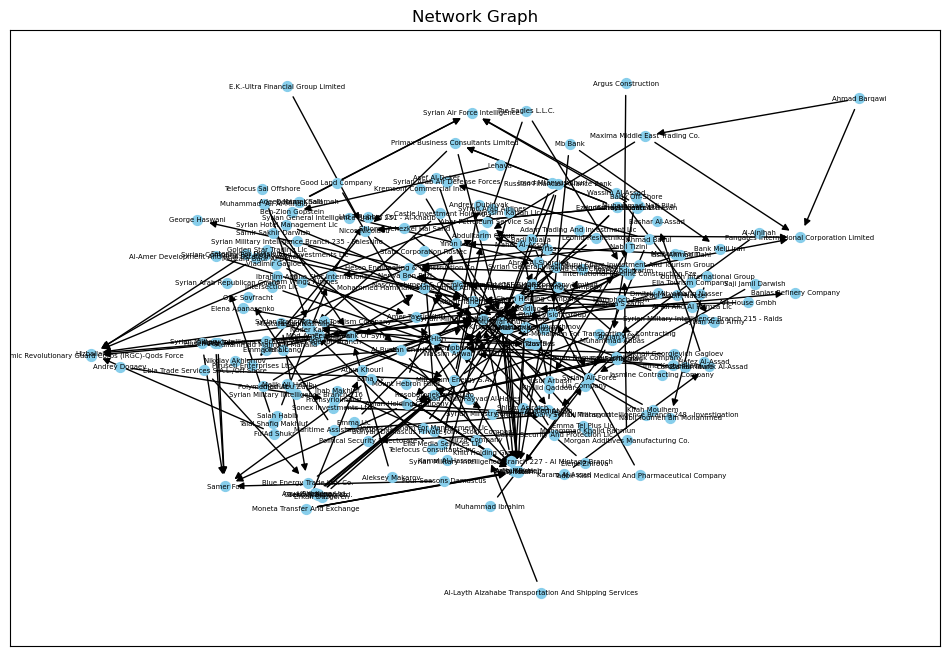

In [58]:
df = pd.read_csv("Extracted Data/relationships_mideast.csv")
mideast_graph = create_graph(df, types_df)
visualize_network_graph(mideast_graph)

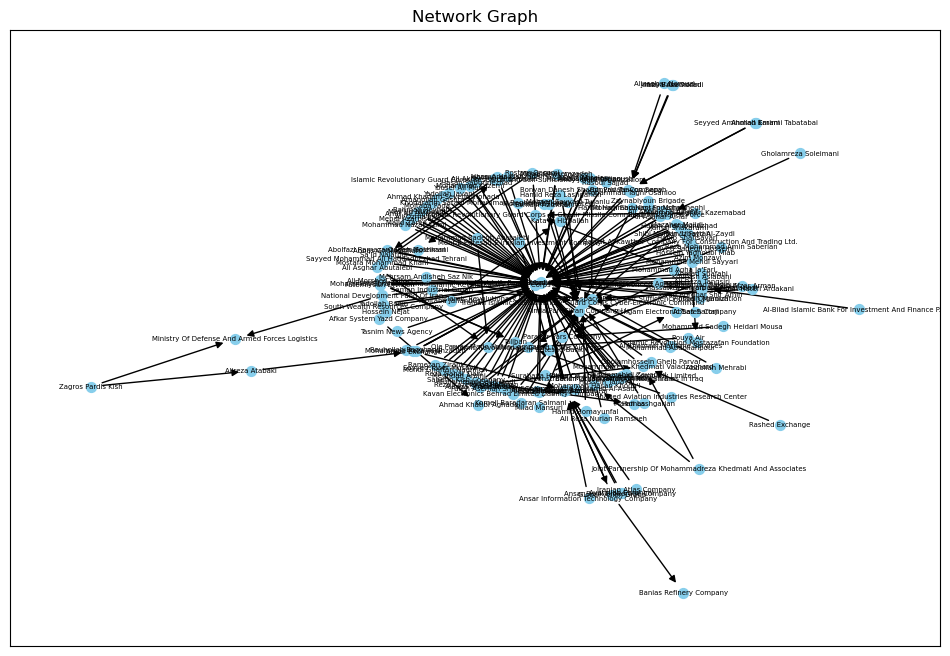

In [59]:
df = pd.read_csv("Extracted Data/relationships_irgc.csv")
irgc_graph = create_graph(df, types_df)
visualize_network_graph(irgc_graph)

## Merge Graphs

![](https://external-preview.redd.it/hiu5Y-qTIBfzkKh2R97zjaMBhCluDBFTRp7Rs7n5uI8.jpg?auto=webp&s=af34175fb9e56c78106e48296d8a9d5ed0a14ebb)

In [60]:
def combine_graphs(left_graph, right_graph):
    
    # Create a copy of x_graph to maintain the original
    combined_graph = left_graph.copy()

    # Add nodes from y_graph if they exist in x_graph
    for node in right_graph.nodes():
        if node in combined_graph:
            combined_graph.add_node(node, **right_graph.nodes[node])

    # Add edges from y_graph if the nodes exist in x_graph
    for u, v, data in right_graph.edges(data = True):
        if u in combined_graph and v in combined_graph:
            combined_graph.add_edge(u, v, **data)
            logger.debug("Edge added")

    return combined_graph

combined_graph = combine_graphs(irgc_graph, mideast_graph)

2024-10-16 21:48:27.474 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.476 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.477 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.477 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.478 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.479 | DEBUG    | __main__:combine_graphs:15 - Edge added


169


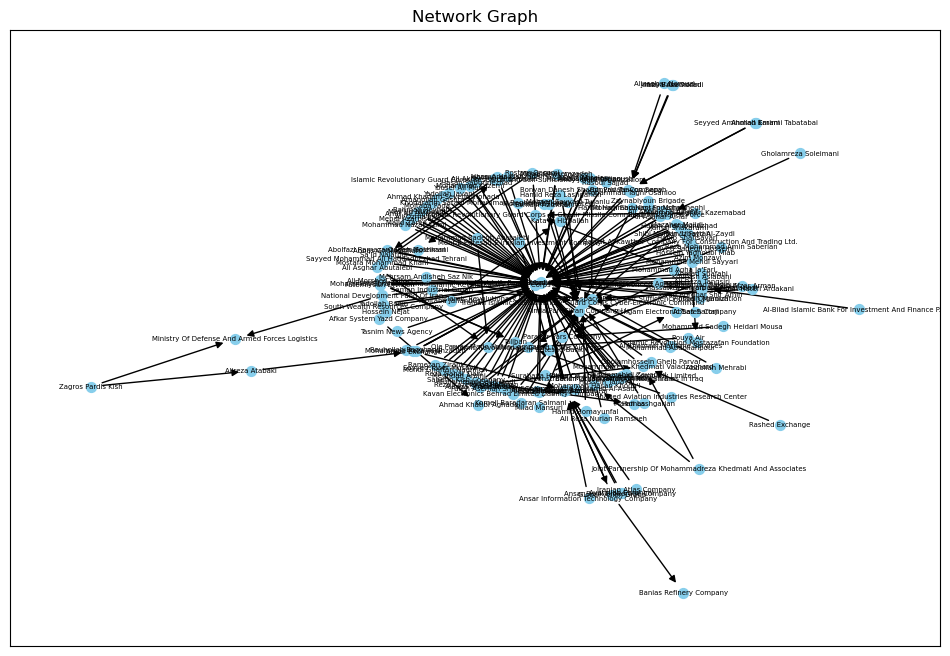

In [53]:
print(len(combined_graph))
visualize_network_graph(combined_graph)

In [62]:
combined_graph.nodes()

NodeView(('Javad Bordbar Shir Amin', 'Pishgam Electronic Safeh Company', 'Hassan Shahvarpour Najafabadi', 'Mohammad Pakpour', 'Al-Bilad Islamic Bank For Investment And Finance P.S.C.', 'Kourosh Asiabani', 'Ahmad Shafahi', 'Reza Mohammad Amin Saberian', 'Hasan Arambunezhad', 'Azim Monzavi', 'Hossein Yaghoubi Miab', 'Mohammad Mehdi Sayyari', 'Bahjat Al Kawthar Company For Construction And Trading Ltd.', 'Seyed Sadegh Hosseini', "Shibl Muhsin 'Ubayd Al-Zaydi", 'Saeed Aghajani', 'Habib Shahsavari', 'Ali Reza Tangsiri', 'Parviz Fattah', 'Jamal Shakarami', 'Mazaher Majidi', 'Bonyad Taavon Sepah', 'Ali Asghar Al-Taf', 'Zaynabiyoun Brigade', 'Ali Ahmad Faizullahi', 'Jahan Aras Kish', 'Mohammad Hassan Mohagheghi', 'Mahmud Bagheri Kazemabad', 'Mohammadreza Khedmati Valadzaghard', 'Hamid Hajji Ebrahimi Forushani', 'Banias Refinery Company', 'Mohammad Taghi Osanloo', 'Rasoul Sajjad', 'National Development Fund Of Iran', "Kata'Ib Hizballah", 'Masoud Shoushtaripousti', 'Gholamreza Soleimani', 'Alias

## Save Graph as CSV

In [27]:
import pandas as pd
import networkx as nx

# Assume the graph G is already created

# Extract node data
nodes_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
nodes_data.index.name = 'entity'

# Extract edge data with additional attributes
edges_data = []

for u, v, data in G.edges(data=True):
    edge = {'entity_1': u, 'entity_2': v}
    edge.update(data)
    edges_data.append(edge)
    
edges_data = pd.DataFrame(edges_data)

# Save nodes and edges to CSV files
nodes_data.to_csv('nodes_data.csv')
edges_data.to_csv('edges_data.csv')

print("Node and edge data saved to 'nodes_data.csv' and 'edges_data.csv'")

# Combine them into one CSV file:
combined_data = edges_data.merge(nodes_data, left_on='entity_1', right_index=True, how='left', suffixes=('', '_entity_1'))
combined_data = combined_data.merge(nodes_data, left_on='entity_2', right_index=True, how='left', suffixes=('', '_entity_2'))
combined_data.to_csv('network_data.csv', index=False)

print("Network data saved to 'network_data.csv'")



Node and edge data saved to 'nodes_data.csv' and 'edges_data.csv'
Network data saved to 'network_data.csv'
